# Neural Scattering Fields Demo (TBD)
In this notebook, we use our `misty-lego-bulldozer` scene to demonstrate our multiple-scattering NeRF.\
(Alternatively to this demo, you can also run the model from the command line using `python3 run_nerf.py <path to data> <output path> <environment map path>`)

First, we start by fetching and processing the data (images and poses).

In [25]:
# autoreload imports for dev
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import os
import utils

# get train and test data
train_dict  = utils.load_transforms_json(os.path.join(os.getcwd(), "data", "lego"), "transforms_train.json")
test_dict   = utils.load_transforms_json(os.path.join(os.getcwd(), "data", "lego"), "transforms_test.json")
train_imgs  = utils.get_images_from_folder(os.path.join(os.getcwd(), "data", "lego", "train"))
test_imgs   = utils.get_images_from_folder(os.path.join(os.getcwd(), "data", "lego", "test"))

### Camera Pose Visualization
As a sanity check, we can visualize the camera positions and their viewing directions.\
Here, it looks good; all cameras are looking inward towards our scene object.\
We can also visualize our expected test poses, which is a continuous loopy path around the object.

Train poses:


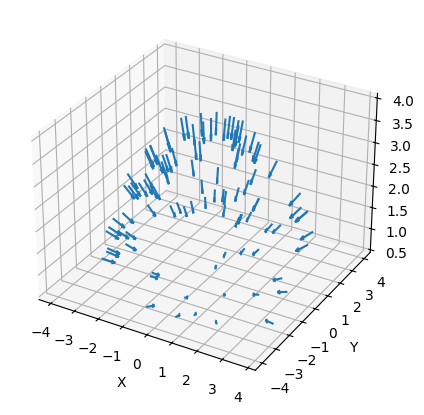

Test poses:


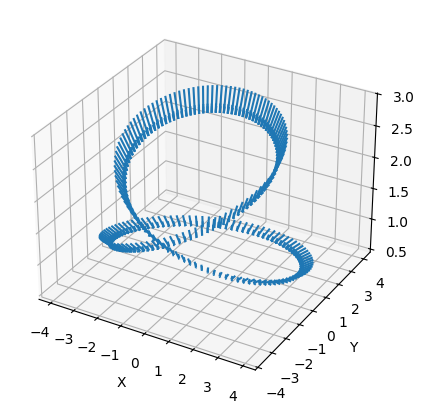

In [ ]:
import render
import ms_nerf as ms
import torch

train_poses = train_dict["poses"]
test_poses  = test_dict["poses"]
focal = train_dict["focal"][0]
print("Train poses:")
utils.ray_plot(*render.get_camera_poses(train_poses))
print("Test poses:")
utils.ray_plot(*render.get_camera_poses(test_poses))

## Ray Tracing
Just as a ray tracer does, we shoot a ray through each "pixel" of the virtual image plane.

In [153]:
import numpy as np

def local_to_world_rotation(target_dir):
    """
    Constructs a rotation matrix to convert directions from a local coordinate system 
    (where +z is aligned with `target_dir`) to world coordinates.
    
    Args:
        target_dir (np.ndarray): [3,] The direction vector in world coordinates (e.g., [a, b, c]).
    
    Returns:
        R (np.ndarray): [3,3] Rotation matrix.
    """
    target_dir = target_dir / np.linalg.norm(target_dir)  # Normalize
    
    # Choose a temporary "up" vector (avoid alignment issues)
    temp_up = np.array([0, 0, 1], dtype=np.float32)
    if np.abs(np.dot(target_dir, temp_up)) > 0.9:
        temp_up = np.array([0, 1, 0], dtype=np.float32)  # Fallback
    
    # Compute tangent (local x-axis)
    tangent = np.cross(target_dir, temp_up)
    tangent = tangent / np.linalg.norm(tangent)
    
    # Compute bitangent (local y-axis)
    bitangent = np.cross(target_dir, tangent)
    bitangent = bitangent / np.linalg.norm(bitangent)
    
    # Rotation matrix: columns are tangent, bitangent, target_dir
    R = np.stack([tangent, bitangent, target_dir], axis=1)
    return R

# Example usage
world_dir = np.array([1, 1, 0], dtype=np.float32)  # Target direction (world coordinates)
local_dir = np.array([-1, 0, -1.0], dtype=np.float32)  # Local direction (aligned with target_dir)
world_dir /= np.linalg.norm(world_dir)
local_dir /= np.linalg.norm(local_dir)

# Get rotation matrix
R = local_to_world_rotation(world_dir)

# Convert local direction to world coordinates
world_space_dir = np.dot(R, local_dir)
print(world_space_dir)  # Output: [1, 0, 0] (matches target_dir)

[-1.0000000e+00 -2.5032577e-08  0.0000000e+00]


## Network
After this, we set up our component modules for our `NeuralScatteringField`, defined in `ms_nerf.py`.

### Positional Encoder

In [46]:
x_encoder = ms.PositionalEncoder(3, 8, include_input=True, device="cpu") # change to 'cuda' when working for real
d_encoder = ms.PositionalEncoder(3, 1, include_input=True, device="cpu") # change to 'cuda' when working for real
x_enc = x_encoder(train_poses)
d_enc = d_encoder(train_poses)
print(x_enc.shape, d_enc.shape)

torch.Size([128, 51]) torch.Size([128, 9])


### Intemediate Networks

### Forward Pass

#### An example of phase function sampling (Henyey-Greenstein vs Uniform Sampling)
This is what we use to sample rays in single-scattering.\
**NOTE:** Sampling using `sample_next_directions` is relative to the ray coordinate frame.\
These need to be transformed into the world frame by using `local_to_world_rotation`.

torch.Size([6, 64, 2])


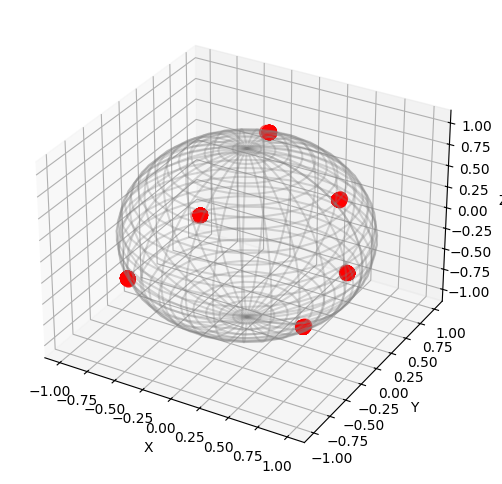

In [ ]:
# test code
# from utils import cartesian_to_spherical
# from render import eval_env_map
# from PIL import Image

# theta_phi = cartesian_to_spherical(sample_next_directions(torch.rand(6,3) * 2 - 1, phase_function=lambda u,v:sample_henyey_greenstein(u,v,g=0.9999), num_samples=64))
# print(theta_phi.shape)
# visualize_spherical_samples(*theta_phi.T)
# eval_env_map(torch.rand(16,3), torch.tensor(np.array(Image.open("env_map_example.png")))[...,:3])


[PDF] 0.999 aligned at g=0.99:	 307.8355811394921
[PDF] 0.999 aligned at g=0.9999: 5.627117655687526


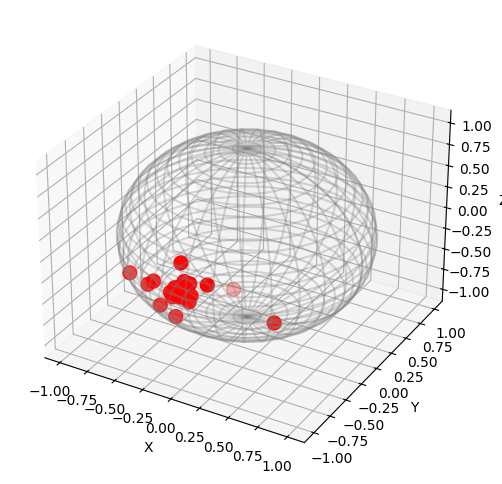

In [589]:
from render import henyey_greenstein_pdf, sample_henyey_greenstein
from sh import visualize_spherical_samples
from utils import local_to_world_rotation, spherical_to_cartesian, cartesian_to_spherical

# local to world position
ray_dir = torch.tensor([0,-1,0], dtype=torch.float32)  # w.r.t world
R = local_to_world_rotation(ray_dir.reshape(-1,3))

# generate samples; play with 'g' and see how sampling densities change throughout the spherical area
# NOTE: lots of discrepancy between 0.99 and 0.9999. The sensitivity to change is highly non-linear
# (maybe this could impact training? Maybe there's a transformation that can make this behave better.)
# additonally, if you check the henyey_greenstein_pdf, you can see that if g ~= 1, then even the smallest offset
# of cos_theta can go from extremely high probability density to very low ones.
print("[PDF] 0.999 aligned at g=0.99:\t", henyey_greenstein_pdf(1 - 1e-4, g=0.99))
print("[PDF] 0.999 aligned at g=0.9999:", henyey_greenstein_pdf(1 - 1e-4, g=0.9999))

theta_phi = sample_henyey_greenstein(*torch.rand(2, 128), g=0.99) # w.r.t the current ray direction
local_dirs = spherical_to_cartesian(theta_phi) # (num_samples, 3)
world_dirs = torch.einsum("bij,kj->bki", R, local_dirs)
theta_phi = cartesian_to_spherical(world_dirs.squeeze(0))
visualize_spherical_samples(*theta_phi.T)

Below is the same visualization, but using an **isotropic phase function**, which is equivalent to g=0.\
This is used in multiple scattering using the learned SH coefficients from the SH network.

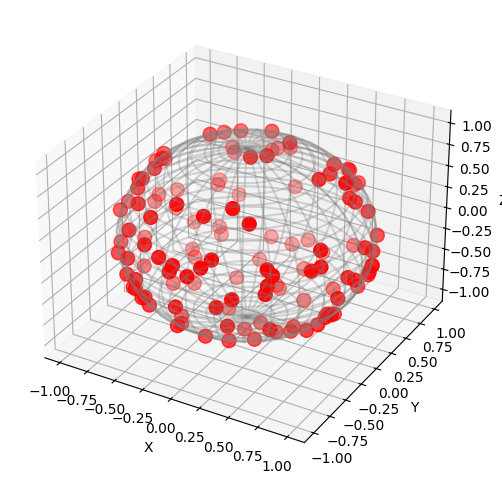

In [590]:
from sh import visualize_spherical_samples
from render import sample_isotropic
# because uniform/isotropic distribution, we can omit ray to world frame transformations
# since all directions are equally likely

# generate samples; play with 'g' and see how sampling densities change throughout the spherical area
theta_phi2 = sample_isotropic(*torch.rand(2, 128))
visualize_spherical_samples(*theta_phi2.T)

## Training
Here, we borrow training metadata from the *Neural Relightable Participating Media Rendering* (Zheng et al.) paper.\
At the current time of construction, our model is pretty much the same as theirs, except ours is more constrained in only allowing environment map lighting.\
We train the model for 200K iterations, with a batch of 1200 primary rays each batch.\
We also decay the learning rate from $1\times 10^{-4}\to 1\times 10^{-5}$.

In [ ]:
# call training loop from ms_nerf

## Testing
Here, we render the scene using test poses unseen during training.

In [ ]:
# choose some random test poses and render their views